<a href="https://colab.research.google.com/github/andriyolo/Breadth-First-Search/blob/master/assignment2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group members
Nome            | Email                            | Id
----------------|----------------------------------|---------------
Luigi Porcelli  | luigi.porcelli@studio.unibo.it   |0001077036
Davide Bombardi |davide.bombardi@studio.unibo.it   |0001092240
Stefano Andriolo| stefano.andriolo3@studio.unibo.it|0001148164


# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 37 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# PyTorch dataset
from torchvision import datasets
from torchvision.transforms import v2
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
class_names = [
    "Apple",
    "Avocado",
    "Banana",
    "Kiwi",
    "Lemon",
    "Lime",
    "Mango",
    "Melon",
    "Nectarine",
    "Orange",
    "Papaya",
    "Passion-Fruit",
    "Peach",
    "Pear",
    "Pineapple",
    "Plum",
    "Pomegranate",
    "Red-Grapefruit",
    "Satsumas",
    "Juice",
    "Milk",
    "Oatghurt",
    "Oat-Milk",
    "Sour-Cream",
    "Sour-Milk",
    "Soyghurt",
    "Soy-Milk",
    "Yoghurt",
    "Asparagus",
    "Aubergine",
    "Cabbage",
    "Carrots",
    "Cucumber",
    "Garlic",
    "Ginger",
    "Leek",
    "Mushroom",
    "Onion",
    "Pepper",
    "Potato",
    "Red-Beet",
    "Tomato",
    "Zucchini"
]
print(len(class_names))

43


## Preprocessing and data exploration

Before starting, a few considerations on the dataset:
- The image dimensions are not consistent, so a resize/crop is necessary
- The images are all photo (presumably) taken in grocery shops, so we can assume same lighting and they're all RGB images.
- The classes are imbalanced, with peaks on Apple, Juice, Yoghurt, Milk and Melon (see class weights).

In [ ]:
# Data transform to convert data to a tensor and apply normalization

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop((348,348)),
    v2.JPEG(80), #applies image compression to the dataset
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.CenterCrop((348,348)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
train_dataset = GroceryStoreDataset(split="train", transform=train_transform)
valid_dataset = GroceryStoreDataset(split="val", transform=test_transform)
test_dataset = GroceryStoreDataset(split="test", transform=test_transform)

In [ ]:
# number of subprocesses to use for data loading
num_workers = 2

batch_size = 16

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

Number of training examples: 2640
Number of validation examples: 296
Number of classes: 43
Image 1 shape: (3, 348, 348)
Image 2 shape: (3, 348, 348)
Image 3 shape: (3, 348, 348)
Image 4 shape: (3, 348, 348)
Image 5 shape: (3, 348, 348)
Image 6 shape: (3, 348, 348)
Image 7 shape: (3, 348, 348)
Image 8 shape: (3, 348, 348)
Image 9 shape: (3, 348, 348)
Image 10 shape: (3, 348, 348)


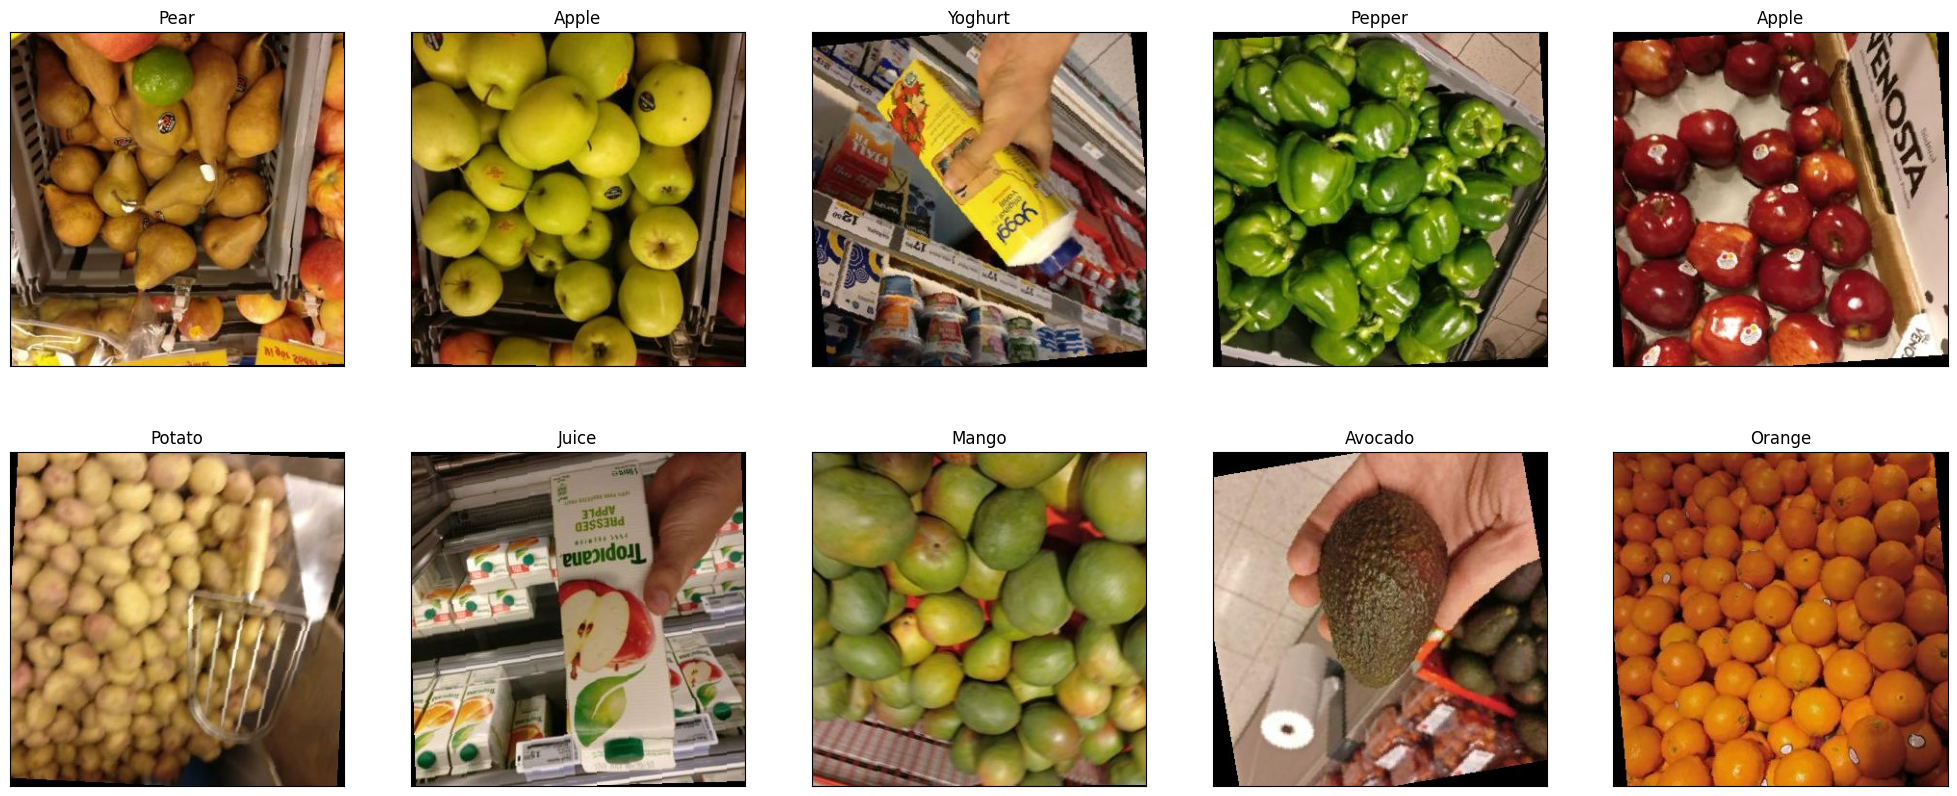

In [ ]:
train_dataset = GroceryStoreDataset(split="train")
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")
print(f"Number of classes: {train_dataset.get_num_classes()}")

#display 10 images

dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[labels[idx]])
    print(f"Image {idx+1} shape: {tuple(images[idx].size())}")

In [ ]:

labels = torch.tensor([label for _, label in train_dataset])
class_counts = torch.bincount(labels, minlength=43)
class_weights = 1.0 / (class_counts.float() + 1e-6)  # Add small epsilon to avoid division by zero

class_weights = torch.log1p(class_weights)

# Normalize class weights (optional)
class_weights = class_weights / class_weights.sum()
if train_on_gpu:
    class_weights = class_weights.to('cuda')

print(class_weights)

tensor([0.0031, 0.0206, 0.0188, 0.0184, 0.0201, 0.0272, 0.0263, 0.0055, 0.0234,
        0.0149, 0.0398, 0.0300, 0.0228, 0.0073, 0.0323, 0.0380, 0.0323, 0.0248,
        0.0121, 0.0035, 0.0047, 0.0255, 0.0263, 0.0176, 0.0280, 0.0166, 0.0141,
        0.0047, 0.0519, 0.0380, 0.0439, 0.0197, 0.0300, 0.0335, 0.0439, 0.0364,
        0.0217, 0.0222, 0.0076, 0.0113, 0.0462, 0.0067, 0.0280],
       device='cuda:0')


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In our training method, we implemented a few techniques in order to try to achieve the best results while not wasting computational time:
- Early Stopping: whenever the validation loss doesn't decrease by a given delta for a number (patience) of epochs, the training will be interrupted since it is failing to generalize or learn, saving computational time.
- Learning Rate Scheduler: If the validation loss doesn't decrease by a delta for a number (patience) of epochs, the learning rate will be lowered; this will help the model to converge to a minimum.

The method was build as flexible as possible in order to make as many tests as possible. At the end of the training, the model that achieved the best accuracy is saved, even though we could store also the weights of the model with the best (lowest) loss.

The method returns the history of loss and accuracy for both training and validation.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def train_model(model,
                train_loader,
                valid_loader,
                optimizer,
                n_epochs=100,
                model_save_path='model_cifar.pt',
                criterion=nn.CrossEntropyLoss(),
                train_on_gpu=True,
                patience=10,
                min_delta=0.01,
                metric='loss',
                verbose=True):

    # Initialize the best metric and early stopping trigger
    valid_loss_min = np.Inf  # best validation loss
    trigger_times = 0  # for early stopping patience

    best_valid_loss = np.Inf
    best_valid_accuracy = -np.Inf


    if metric == 'loss':
        mode = 'min'
    elif metric == 'accuracy':
        mode = 'max'
    else:
        raise ValueError("Invalid metric. Choose 'loss' or 'accuracy'.")

    if train_on_gpu:
        model.cuda()

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=mode, patience=2, factor=0.5, threshold=min_delta)

    # Lists to keep track of loss and accuracy
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_accuracy': [],
        'valid_accuracy': []
    }

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        correct_valid = 0
        total_train = 0
        total_valid = 0

        ###################
        # Train the model #
        ###################
        model.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy during training
            _, pred = torch.max(output, 1)
            correct_train += (pred == target).sum().item()
            total_train += target.size(0)

        #######################
        # Validate the model  #
        #######################
        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)

                # Calculate accuracy during validation
                _, pred = torch.max(output, 1)
                correct_valid += (pred == target).sum().item()
                total_valid += target.size(0)

        # Calculate average losses and accuracy
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid

        # Record metrics in history
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_accuracy'].append(train_accuracy)
        history['valid_accuracy'].append(valid_accuracy)

        # Step the learning rate scheduler based on chosen metric
        if metric == 'loss':
            scheduler.step(valid_loss)
        elif metric == 'accuracy':
            scheduler.step(valid_accuracy)

        # Print training and validation statistics
        print(f"Epoch {epoch}/{n_epochs}")
        print(f"Training Loss: {train_loss:.6f} | Validation Loss: {valid_loss:.6f}")
        print(f"Training Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {valid_accuracy:.2f}%")

        # Get the current learning rate
        if verbose:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Learning Rate: {current_lr:.6e}")

        # Save model if validation metric has improved
        if valid_loss < best_valid_loss - min_delta:
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), model_save_path + '_loss.pt')
            best_valid_loss = valid_loss
            if metric == 'loss':
              trigger_times = 0  # reset trigger times if there’s improvement in loss
        elif metric == 'loss' and (valid_loss >= best_valid_loss - min_delta):
          trigger_times += 1
          if verbose:
                print(f"No significant improvement in validation {metric}. Patience counter: {trigger_times}/{patience}")
        if valid_accuracy > best_valid_accuracy + (min_delta*10):
            print("Validation accuracy improved. Saving model...")
            torch.save(model.state_dict(), model_save_path + '_accuracy.pt')
            best_valid_accuracy = valid_accuracy
            if metric == 'accuracy':
              trigger_times = 0  # reset trigger times if there’s improvement in accuracy
        elif metric == 'accuracy' and (valid_accuracy <= best_valid_accuracy + (min_delta*10)):
          trigger_times += 1
          if verbose:
                print(f"No significant improvement in validation {metric}. Patience counter: {trigger_times}/{patience}")
        print("-" * 50)

        # Stop training early if patience is exhausted
        if trigger_times >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    # Return the history dictionary for analysis or plotting
    return history

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot Loss
    plt.figure(figsize=(12, 5))

    # Loss plotù
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['valid_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Our evaluation method provides accuracy for each class and identifies the class where misclassifications most frequently occur.

In [ ]:
def evaluate_model(model,
                   test_loader,
                   model_path=''):

  if model_path != '':
    model.load_state_dict(torch.load(model_path))

  model.cuda()
  # track test loss
  valid_loss = 0.0
  class_correct = list(0. for i in range(43))
  class_total = list(0. for i in range(43))

  # Dictionary to track wrong predictions: {true_label: {predicted_label: count}}
  misclassified = {i: {j: 0 for j in range(43)} for i in range(43)}

  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss
      valid_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.cpu().numpy()) if train_on_gpu else np.squeeze(correct_tensor.numpy())
      # calculate test accuracy for each object class and track misclassifications
      for i in range(len(target)):
          label = target.data[i]
          if not correct[i]:
              # Track misclassification: increment predicted label count for this true label
              misclassified[label.item()][pred[i].item()] += 1
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # average test loss
  valid_loss = valid_loss / len(test_loader.dataset)
  print("\n*** Model Evaluation Report ***")
  print("Validation Loss: {:.6f}".format(valid_loss))
  print("\n{:<15} {:<10} {:<10} {:<10} {:<10}".format("Class", "Accuracy", "Correct", "Total", "Most Misclassified As"))

  # Print class-wise accuracy and misclassifications
  for i in range(43):
      if class_total[i] > 0:
          accuracy = 100 * class_correct[i] / class_total[i]
          # Find the most misclassified class for this true label
          most_misclassified_class = max(misclassified[i], key=misclassified[i].get)
          misclassified_count = misclassified[i][most_misclassified_class]

          if misclassified_count > 0:
              misclassified_info = "{:>5s} ({:2d} times)".format(
                  class_names[most_misclassified_class], misclassified_count)
          else:
              misclassified_info = "None"

          print("{:<15} {:<10.2f}% {:<10} {:<10} {:<}".format(
              class_names[i], accuracy, int(class_correct[i]), int(class_total[i]), misclassified_info))
      else:
          print("{:<15} {:<10} {:<10} {:<10} {:<}".format(
              class_names[i], "N/A", "-", "-", "N/A (no examples)"))

  print("\nOverall Accuracy: {:2d}% ({:2d}/{:2d})".format(
      int(100. * np.sum(class_correct) / np.sum(class_total)),
      int(np.sum(class_correct)), int(np.sum(class_total))))
  print("\n*** End of Report ***")


## Part 1. Models and approaches comparison

For this part, we will provide 3 different models. The given models are very similar in structure, but with some changes in hyperparameters, like the stride, padding, number of kernels in convolutional layers.

With those three models, many experiments will be carried out, with a tuning on the starting learning rate, fine-tuning on weights decay and using class weights in the Loss Function.

In [ ]:
# define the CNN architecture
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(128 * 10 * 10, 500)
        # linear layer (500 -> 43)
        self.fc2 = nn.Linear(500, 43)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.size())
        # flatten image input
        x = x.view(-1, 128 * 10 * 10)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after conv1

        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2

        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3

        # convolutional layer (sees 4x4x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (128 * 7 * 7 -> 500)
        self.fc1 = nn.Linear(128 * 10 * 10, 500)
        # linear layer (500 -> 43)
        self.fc2 = nn.Linear(500, 43)

        # dropout layer (p=0.3)
        self.dropout30 = nn.Dropout(0.40)  # Adjusted dropout rate
        self.dropout50 = nn.Dropout(0.20)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers, with batch norm
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        #print(x.size())
        # flatten image input
        x = x.view(-1, 128 * 100)

        # add dropout layer
        x = self.dropout50(x)
        # add 1st fully connected layer, with relu activation
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout30(x)
        # add 2nd fully connected layer (no activation, final layer)
        x = self.fc2(x)

        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after conv1

        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2

        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3

        # convolutional layer (sees 4x4x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (128 * 7 * 7 -> 500)
        self.fc1 = nn.Linear(128 * 3 * 3, 500)
        # linear layer (500 -> 43)
        self.fc2 = nn.Linear(500,  43)

        # dropout layer (p=0.3)
        self.dropout30 = nn.Dropout(0.50)  # Adjusted dropout rate
        self.dropout50 = nn.Dropout(0.20)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers, with batch norm
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        #print(x.size())
        # flatten image input
        x = x.view(-1, 128 * 3 * 3)

        # add dropout layer
        x = self.dropout50(x)
        # add 1st fully connected layer, with relu activation
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout30(x)
        # add 2nd fully connected layer (no activation, final layer)
        x = self.fc2(x)

        return x


### Model 1

Epoch 1/50
Training Loss: 3.100584 | Validation Loss: 2.808311
Training Accuracy: 16.78% | Validation Accuracy: 22.30%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.429787 | Validation Loss: 2.596901
Training Accuracy: 27.46% | Validation Accuracy: 20.27%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 1.883486 | Validation Loss: 2.224492
Training Accuracy: 41.82% | Validation Accuracy: 31.08%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.532294 | Validation Loss: 2.086934
Training Accuracy: 48.45% | Validation Accuracy: 37.16%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...

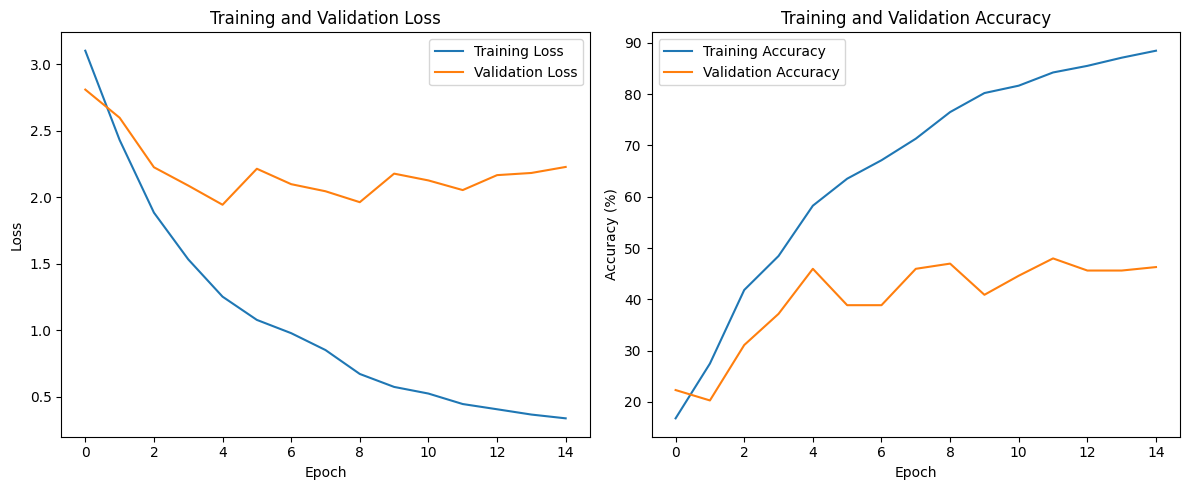

<ipython-input-18-c392ca2c22af>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 2.053043

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           63.64     % 14         22          Pear ( 3 times)
Avocado         60.00     % 3          5          Apple ( 1 times)
Banana          66.67     % 4          6          Lemon ( 1 times)
Kiwi            40.00     % 2          5          Passion-Fruit ( 2 times)
Lemon           60.00     % 3          5          Melon ( 2 times)
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           55.00     % 11         20         Oat-Milk ( 2 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Avocado ( 3 times)
Peach           20.00     % 1          5          Apple ( 3 t

<ipython-input-18-c392ca2c22af>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.942683

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           63.64     % 14         22          Lime ( 5 times)
Avocado         0.00      % 0          5          Juice ( 2 times)
Banana          83.33     % 5          6          Melon ( 1 times)
Kiwi            20.00     % 1          5          Melon ( 2 times)
Lemon           40.00     % 2          5          Melon ( 3 times)
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           55.00     % 11         20         Cabbage ( 2 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          100.00    % 5          5          None
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5           Milk ( 2 times)
Peach           0.00      % 0          5          Apple ( 5 times)
Pear            0.00

In [ ]:
# create a complete CNN
model = Net1()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model_path = 'model_net1'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net1_accuracy.pt'

best_model = Net1()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net1_loss.pt'

best_model = Net1()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

### Model 2

Epoch 1/50
Training Loss: 3.059037 | Validation Loss: 2.395241
Training Accuracy: 20.76% | Validation Accuracy: 30.74%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.311066 | Validation Loss: 2.224297
Training Accuracy: 32.01% | Validation Accuracy: 34.80%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 1.982074 | Validation Loss: 2.050711
Training Accuracy: 38.90% | Validation Accuracy: 37.50%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.820163 | Validation Loss: 2.184183
Training Accuracy: 42.61% | Validation Accuracy: 36.49%
Learning Rate: 5.000000

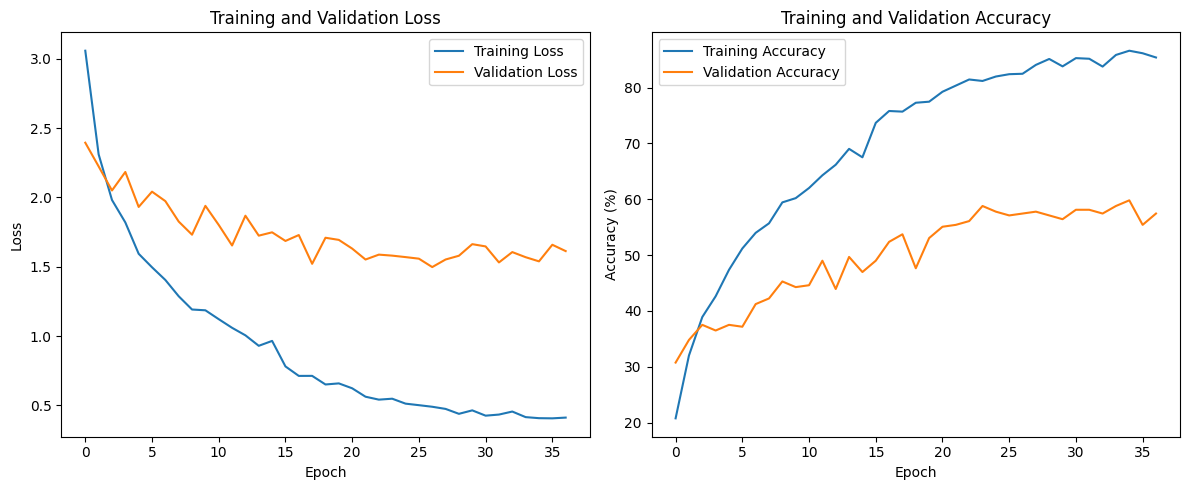

<ipython-input-19-12f107149e7d>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.539278

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           68.18     % 15         22          Pear ( 2 times)
Avocado         0.00      % 0          5          Apple ( 2 times)
Banana          33.33     % 2          6          Melon ( 2 times)
Kiwi            0.00      % 0          5          Potato ( 4 times)
Lemon           100.00    % 5          5          None
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           85.00     % 17         20         Avocado ( 1 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5           Milk ( 2 times)
Peach           20.00     % 1          5          Apple ( 3 times)
Pear            

<ipython-input-19-12f107149e7d>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.498021

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           63.64     % 14         22         Cabbage ( 4 times)
Avocado         0.00      % 0          5          Pineapple ( 3 times)
Banana          33.33     % 2          6          Melon ( 2 times)
Kiwi            0.00      % 0          5          Potato ( 3 times)
Lemon           80.00     % 4          5          Melon ( 1 times)
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           80.00     % 16         20         Avocado ( 1 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5           Milk ( 2 times)
Peach           20.00     % 1          5          Apple ( 4 times

In [ ]:
# create a complete CNN
model = Net2()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model_path = 'model_net2_2'
+
history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net2_2_accuracy.pt'

best_model = Net2()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net2_2_loss.pt'

best_model = Net2()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

Epoch 1/50
Training Loss: 3.209916 | Validation Loss: 2.662115
Training Accuracy: 19.05% | Validation Accuracy: 27.70%
Learning Rate: 8.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.421006 | Validation Loss: 2.365930
Training Accuracy: 28.48% | Validation Accuracy: 30.41%
Learning Rate: 8.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 2.100462 | Validation Loss: 2.173651
Training Accuracy: 35.68% | Validation Accuracy: 36.15%
Learning Rate: 8.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.895836 | Validation Loss: 2.265421
Training Accuracy: 39.58% | Validation Accuracy: 32.43%
Learning Rate: 8.000000

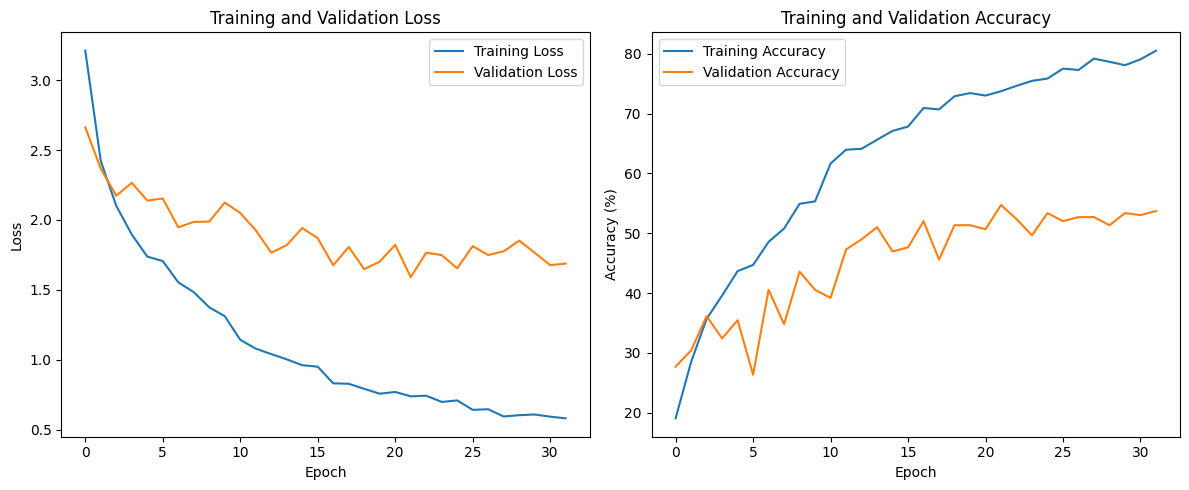

<ipython-input-20-8358d6d2395d>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.590845

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           50.00     % 11         22          Pear ( 4 times)
Avocado         0.00      % 0          5          Apple ( 2 times)
Banana          66.67     % 4          6          Melon ( 1 times)
Kiwi            20.00     % 1          5          Potato ( 3 times)
Lemon           100.00    % 5          5          None
Lime            80.00     % 4          5          Apple ( 1 times)
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           55.00     % 11         20         Sour-Cream ( 2 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   20.00     % 1          5          Avocado ( 1 times)
Peach           20.00     % 1          5          Potato ( 2 times

<ipython-input-20-8358d6d2395d>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.590845

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           50.00     % 11         22          Pear ( 4 times)
Avocado         0.00      % 0          5          Apple ( 2 times)
Banana          66.67     % 4          6          Melon ( 1 times)
Kiwi            20.00     % 1          5          Potato ( 3 times)
Lemon           100.00    % 5          5          None
Lime            80.00     % 4          5          Apple ( 1 times)
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           55.00     % 11         20         Sour-Cream ( 2 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   20.00     % 1          5          Avocado ( 1 times)
Peach           20.00     % 1          5          Potato ( 2 times

In [ ]:
# create a complete CNN
model = Net2()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)

model_path = 'model_net2_4'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net2_4_accuracy.pt'

best_model = Net2()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net2_4_loss.pt'

best_model = Net2()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

Epoch 1/50
Training Loss: 3.123421 | Validation Loss: 2.705459
Training Accuracy: 21.17% | Validation Accuracy: 24.32%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.326269 | Validation Loss: 2.233013
Training Accuracy: 32.77% | Validation Accuracy: 32.77%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 2.030232 | Validation Loss: 2.022701
Training Accuracy: 36.67% | Validation Accuracy: 34.12%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.830756 | Validation Loss: 2.316804
Training Accuracy: 42.27% | Validation Accuracy: 34.80%
Learning Rate: 5.000000

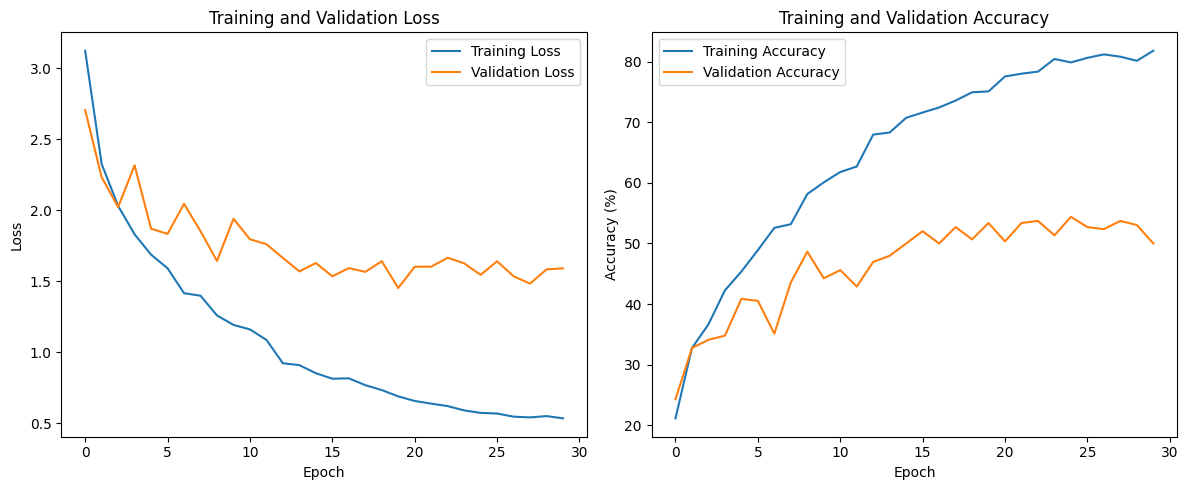

<ipython-input-21-138afce037dd>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.545176

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           59.09     % 13         22          Pear ( 3 times)
Avocado         0.00      % 0          5          Apple ( 2 times)
Banana          50.00     % 3          6           Pear ( 2 times)
Kiwi            0.00      % 0          5          Potato ( 4 times)
Lemon           100.00    % 5          5          None
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Juice ( 1 times)
Melon           65.00     % 13         20         Oat-Milk ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Juice ( 2 times)
Peach           20.00     % 1          5          Apple ( 4 times)
Pear           

<ipython-input-21-138afce037dd>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.452514

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           68.18     % 15         22          Pear ( 3 times)
Avocado         20.00     % 1          5          Pineapple ( 3 times)
Banana          50.00     % 3          6          Mango ( 1 times)
Kiwi            20.00     % 1          5          Potato ( 3 times)
Lemon           100.00    % 5          5          None
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3           Milk ( 1 times)
Melon           65.00     % 13         20         Oat-Milk ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Juice ( 2 times)
Peach           20.00     % 1          5          Apple ( 3 times)
Pear       

In [ ]:
# create a complete CNN
model = Net2()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.000001)

model_path = 'model_net2_6'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net2_6_accuracy.pt'

best_model = Net2()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net2_6_loss.pt'

best_model = Net2()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

In [ ]:
class_weights = class_weights.to('cuda')

### Model 3

Epoch 1/50
Training Loss: 2.965251 | Validation Loss: 2.548548
Training Accuracy: 19.28% | Validation Accuracy: 22.30%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.316297 | Validation Loss: 2.141173
Training Accuracy: 31.74% | Validation Accuracy: 32.09%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 1.955028 | Validation Loss: 1.897141
Training Accuracy: 39.51% | Validation Accuracy: 37.84%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.725916 | Validation Loss: 2.015511
Training Accuracy: 43.18% | Validation Accuracy: 34.46%
Learning Rate: 5.000000

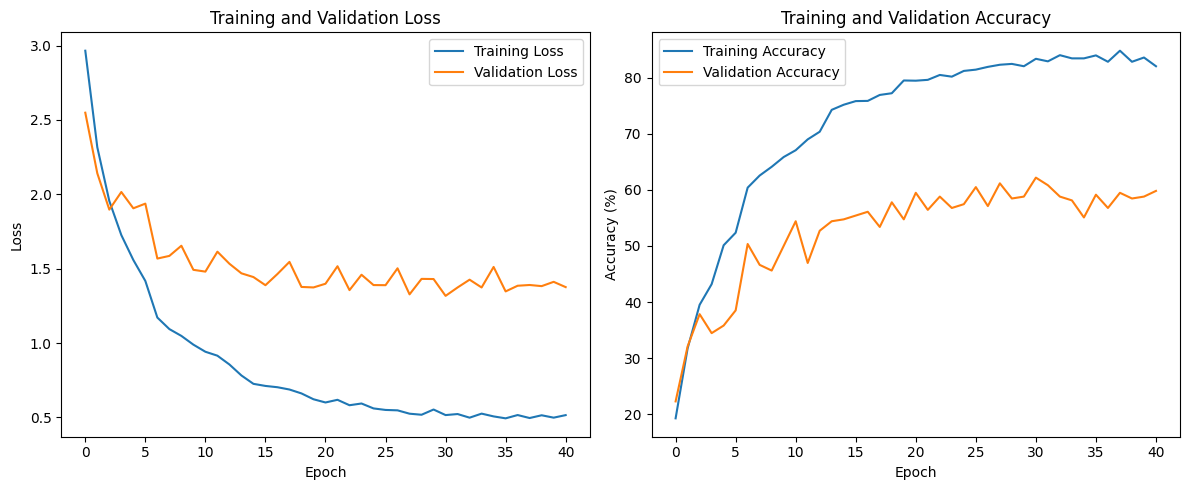

<ipython-input-23-73fe5fd0e8f3>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.317415

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           63.64     % 14         22         Mango ( 4 times)
Avocado         20.00     % 1          5          Cucumber ( 3 times)
Banana          66.67     % 4          6          Melon ( 1 times)
Kiwi            20.00     % 1          5          Melon ( 2 times)
Lemon           100.00    % 5          5          None
Lime            100.00    % 5          5          None
Mango           66.67     % 2          3          Apple ( 1 times)
Melon           85.00     % 17         20         Garlic ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Red-Beet ( 4 times)
Peach           60.00     % 3          5          Pomegranate ( 2 times)
Pear  

<ipython-input-23-73fe5fd0e8f3>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.317415

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           63.64     % 14         22         Mango ( 4 times)
Avocado         20.00     % 1          5          Cucumber ( 3 times)
Banana          66.67     % 4          6          Melon ( 1 times)
Kiwi            20.00     % 1          5          Melon ( 2 times)
Lemon           100.00    % 5          5          None
Lime            100.00    % 5          5          None
Mango           66.67     % 2          3          Apple ( 1 times)
Melon           85.00     % 17         20         Garlic ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Red-Beet ( 4 times)
Peach           60.00     % 3          5          Pomegranate ( 2 times)
Pear  

In [ ]:
# create a complete CNN
model = Net3()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model_path = 'model_net3_2'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net3_2_accuracy.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net3_2_loss.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

Epoch 1/50
Training Loss: 2.971466 | Validation Loss: 2.580172
Training Accuracy: 19.32% | Validation Accuracy: 26.69%
Learning Rate: 8.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.348563 | Validation Loss: 2.109583
Training Accuracy: 30.42% | Validation Accuracy: 35.14%
Learning Rate: 8.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 2.057016 | Validation Loss: 2.088750
Training Accuracy: 36.59% | Validation Accuracy: 36.15%
Learning Rate: 8.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.800349 | Validation Loss: 1.824509
Training Accuracy: 42.54% | Validation Accuracy: 41.55%
Learning Rate: 8.000000

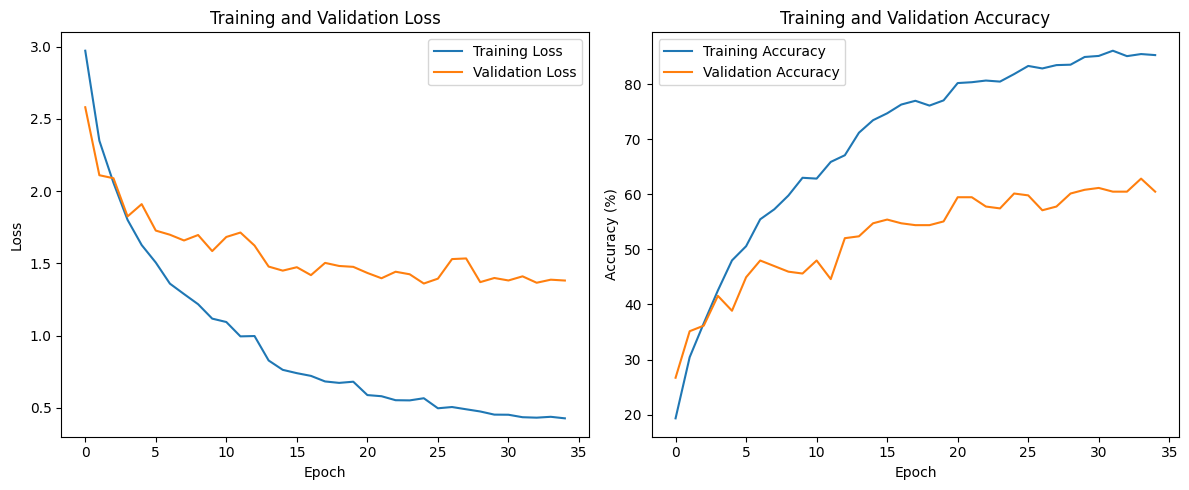

<ipython-input-24-d6af9a9ab79f>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.386459

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           54.55     % 12         22         Mango ( 4 times)
Avocado         20.00     % 1          5          Cucumber ( 3 times)
Banana          66.67     % 4          6          Melon ( 1 times)
Kiwi            40.00     % 2          5          Melon ( 1 times)
Lemon           100.00    % 5          5          None
Lime            100.00    % 5          5          None
Mango           100.00    % 3          3          None
Melon           75.00     % 15         20         Garlic ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          80.00     % 4          5          Satsumas ( 1 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5           Milk ( 3 times)
Peach           40.00     % 2          5          Apple ( 2 times)
Pear            40.00     %

<ipython-input-24-d6af9a9ab79f>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.359906

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           50.00     % 11         22         Mango ( 4 times)
Avocado         20.00     % 1          5          Cucumber ( 2 times)
Banana          50.00     % 3          6          Melon ( 1 times)
Kiwi            40.00     % 2          5          Melon ( 1 times)
Lemon           80.00     % 4          5          Melon ( 1 times)
Lime            100.00    % 5          5          None
Mango           66.67     % 2          3           Kiwi ( 1 times)
Melon           75.00     % 15         20         Garlic ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          20.00     % 1          5          Satsumas ( 4 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5           Milk ( 3 times)
Peach           60.00     % 3          5          Apple ( 1 times)
Pea

In [ ]:
# create a complete CNN
model = Net3()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)

model_path = 'model_net3_4'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net3_4_accuracy.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net3_4_loss.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

Epoch 1/50
Training Loss: 2.962273 | Validation Loss: 2.606305
Training Accuracy: 20.87% | Validation Accuracy: 26.01%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.313106 | Validation Loss: 2.154400
Training Accuracy: 30.80% | Validation Accuracy: 34.46%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 1.937970 | Validation Loss: 2.032695
Training Accuracy: 41.29% | Validation Accuracy: 36.49%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 1.711384 | Validation Loss: 1.869992
Training Accuracy: 45.11% | Validation Accuracy: 37.16%
Learning Rate: 5.000000

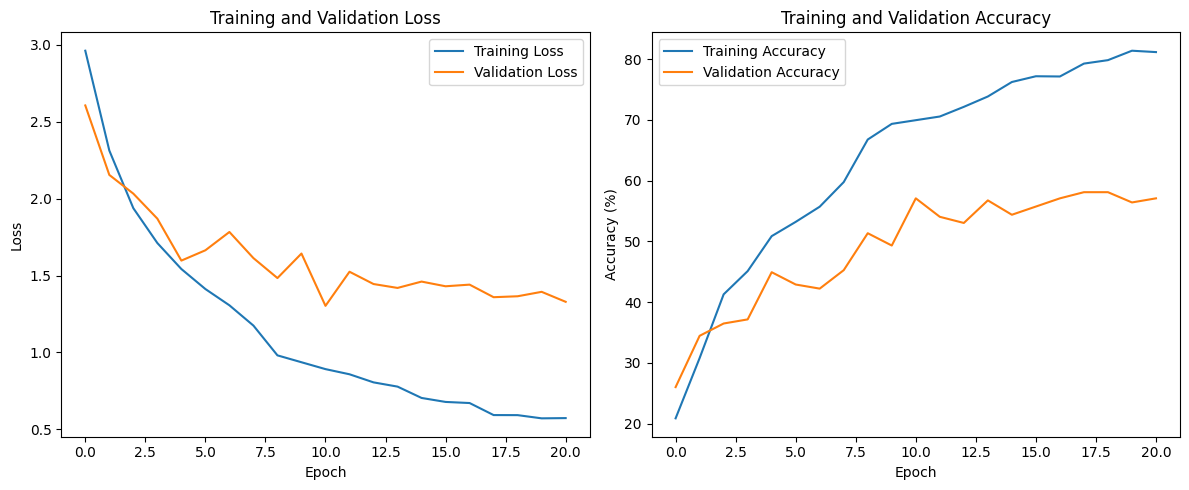

<ipython-input-25-b8746e7b318e>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.359049

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           68.18     % 15         22         Mango ( 2 times)
Avocado         20.00     % 1          5          Cucumber ( 3 times)
Banana          50.00     % 3          6          Lemon ( 1 times)
Kiwi            40.00     % 2          5          Melon ( 2 times)
Lemon           80.00     % 4          5          Satsumas ( 1 times)
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Melon ( 1 times)
Melon           85.00     % 17         20         Garlic ( 2 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Oat-Milk ( 3 times)
Peach           60.00     % 3          5          Apple ( 2 time

<ipython-input-25-b8746e7b318e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.302806

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           81.82     % 18         22          Pear ( 2 times)
Avocado         0.00      % 0          5          Cucumber ( 3 times)
Banana          50.00     % 3          6           Pear ( 2 times)
Kiwi            40.00     % 2          5          Melon ( 2 times)
Lemon           0.00      % 0          5          Melon ( 3 times)
Lime            100.00    % 5          5          None
Mango           33.33     % 1          3          Apple ( 1 times)
Melon           85.00     % 17         20         Avocado ( 1 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Avocado ( 1 times)
Peach           40.00     % 2          5          Apple ( 3 times)


In [ ]:
# create a complete CNN
model = Net3()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.000001)

model_path = 'model_net3_6'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net3_6_accuracy.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net3_6_loss.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

Epoch 1/50
Training Loss: 3.351053 | Validation Loss: 2.889836
Training Accuracy: 10.23% | Validation Accuracy: 15.20%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.661525 | Validation Loss: 2.525334
Training Accuracy: 17.16% | Validation Accuracy: 19.93%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 2.315269 | Validation Loss: 2.289303
Training Accuracy: 22.84% | Validation Accuracy: 28.04%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 2.016451 | Validation Loss: 2.338008
Training Accuracy: 30.53% | Validation Accuracy: 22.97%
Learning Rate: 5.000000

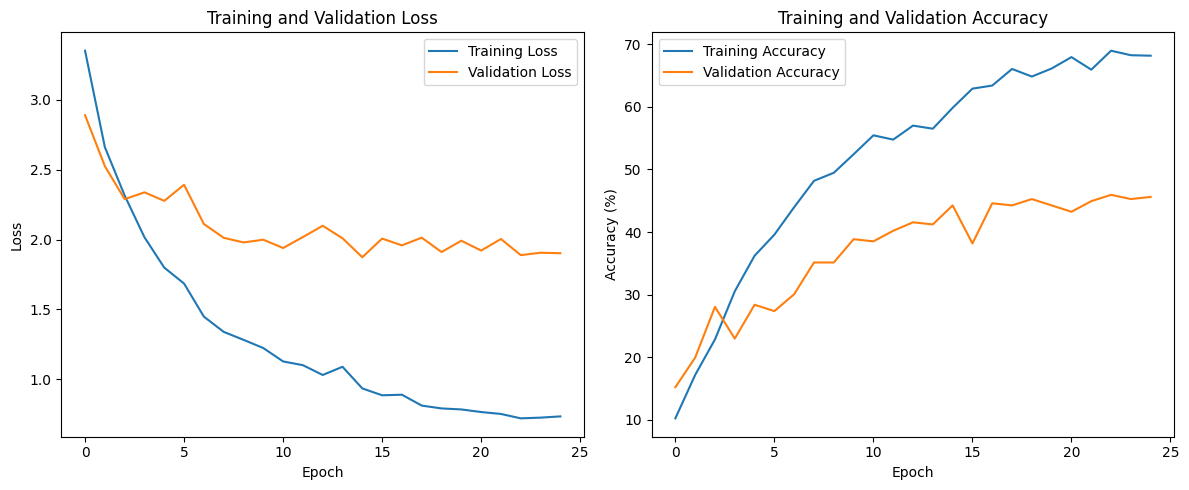

<ipython-input-26-00879975f10e>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.888828

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           18.18     % 4          22         Peach ( 4 times)
Avocado         0.00      % 0          5          Cucumber ( 3 times)
Banana          66.67     % 4          6          Mango ( 1 times)
Kiwi            40.00     % 2          5          Potato ( 2 times)
Lemon           100.00    % 5          5          None
Lime            80.00     % 4          5          Zucchini ( 1 times)
Mango           66.67     % 2          3          Melon ( 1 times)
Melon           40.00     % 8          20         Cabbage ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          20.00     % 1          5          Satsumas ( 4 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Juice ( 2 times)
Peach           20.00     % 1          5          Pomegranate ( 3

<ipython-input-26-00879975f10e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.873772

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           13.64     % 3          22         Cabbage ( 7 times)
Avocado         20.00     % 1          5          Cucumber ( 3 times)
Banana          50.00     % 3          6          Lemon ( 1 times)
Kiwi            40.00     % 2          5          Potato ( 3 times)
Lemon           80.00     % 4          5          Satsumas ( 1 times)
Lime            100.00    % 5          5          None
Mango           0.00      % 0          3          Cabbage ( 2 times)
Melon           30.00     % 6          20         Cabbage ( 6 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Red-Beet ( 2 times)
Peach           0.00      % 0          5          Pomegran

In [ ]:
# create a complete CNN
model = Net3()


criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model_path = 'model_net3_8'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net3_8_accuracy.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net3_8_loss.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

Epoch 1/50
Training Loss: 3.390094 | Validation Loss: 2.868236
Training Accuracy: 8.33% | Validation Accuracy: 14.53%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/50
Training Loss: 2.772011 | Validation Loss: 2.641487
Training Accuracy: 14.66% | Validation Accuracy: 14.86%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/50
Training Loss: 2.395309 | Validation Loss: 2.419312
Training Accuracy: 21.25% | Validation Accuracy: 22.30%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/50
Training Loss: 2.137350 | Validation Loss: 2.245355
Training Accuracy: 27.35% | Validation Accuracy: 28.38%
Learning Rate: 5.000000e

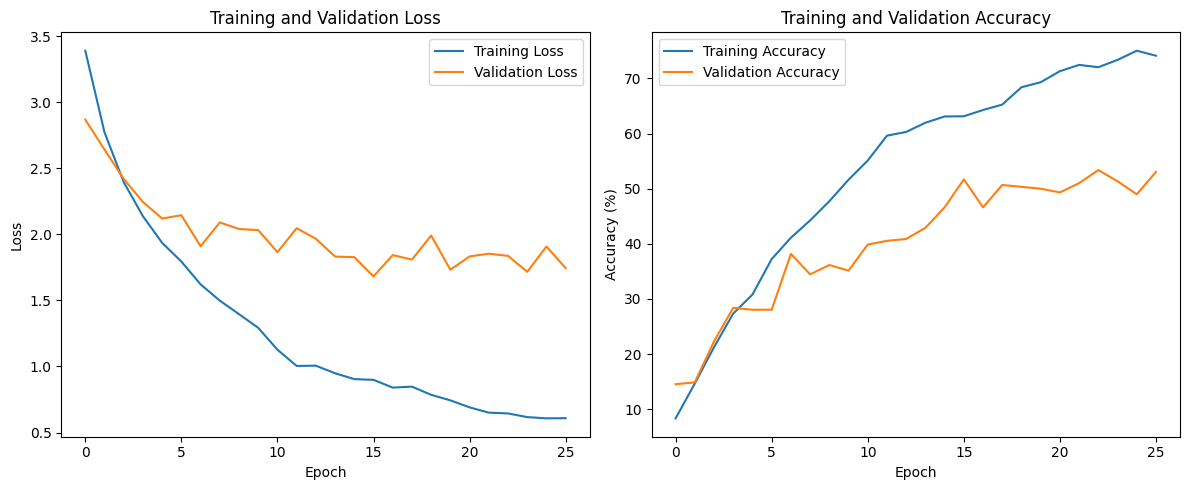

<ipython-input-27-1e9edb3624d9>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_acc))



*** Model Evaluation Report ***
Validation Loss: 1.837342

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           31.82     % 7          22         Cabbage ( 4 times)
Avocado         0.00      % 0          5           Plum ( 2 times)
Banana          50.00     % 3          6          Lemon ( 1 times)
Kiwi            40.00     % 2          5          Melon ( 2 times)
Lemon           100.00    % 5          5          None
Lime            40.00     % 2          5          Zucchini ( 2 times)
Mango           66.67     % 2          3          Papaya ( 1 times)
Melon           55.00     % 11         20          Leek ( 4 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          0.00      % 0          5          Satsumas ( 5 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5           Plum ( 1 times)
Peach           40.00     % 2          5          Pomegranate ( 2 ti

<ipython-input-27-1e9edb3624d9>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path_loss))



*** Model Evaluation Report ***
Validation Loss: 1.681744

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           36.36     % 8          22         Peach ( 4 times)
Avocado         0.00      % 0          5          Cucumber ( 3 times)
Banana          16.67     % 1          6          Lemon ( 3 times)
Kiwi            40.00     % 2          5          Melon ( 1 times)
Lemon           40.00     % 2          5          Satsumas ( 3 times)
Lime            100.00    % 5          5          None
Mango           66.67     % 2          3          Papaya ( 1 times)
Melon           30.00     % 6          20         Papaya ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          40.00     % 2          5          Satsumas ( 3 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   0.00      % 0          5          Juice ( 2 times)
Peach           40.00     % 2          5          Pomegranate ( 2 

In [ ]:
# create a complete CNN
model = Net3()


criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.000001)

model_path = 'model_net3_10'

history = train_model(model, train_loader, valid_loader, n_epochs=50, model_save_path=model_path, criterion=criterion, optimizer=optimizer)

plot_training_history(history)

model_path_acc = 'model_net3_10_accuracy.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_acc))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

model_path_loss = 'model_net3_10_loss.pt'

best_model = Net3()
best_model.load_state_dict(torch.load(model_path_loss))

evaluate_model(best_model, valid_loader)
evaluate_model(best_model, test_loader)

## Conclusions

Working with a

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms


In [ ]:
# Load the pretrained ResNet50 model
model_rn18 = models.resnet18(pretrained=True)

model_rn18.fc = nn.Linear(model_rn18.fc.in_features, 43)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rn18 = model_rn18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model_rn18.parameters(), lr=5e-4)

model_save_path_netrn = 'model_cifar_netrn'

train_model(model_rn18, train_loader, valid_loader, n_epochs=30, model_save_path=model_save_path_netrn, criterion=criterion, optimizer=optimizer)

evaluate_model(model_rn18, valid_loader, model_save_path_netrn+'_accuracy.pt')

evaluate_model(model_rn18, test_loader,model_save_path_netrn+'_loss.pt')

Epoch 1/30
Training Loss: 0.170954 | Validation Loss: 1.270754
Training Accuracy: 94.81% | Validation Accuracy: 76.01%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/30
Training Loss: 0.188039 | Validation Loss: 1.035645
Training Accuracy: 94.77% | Validation Accuracy: 72.30%
Learning Rate: 5.000000e-04
Validation loss improved. Saving model...
--------------------------------------------------
Epoch 3/30
Training Loss: 0.127487 | Validation Loss: 1.251768
Training Accuracy: 96.59% | Validation Accuracy: 72.30%
Learning Rate: 5.000000e-04
No significant improvement in validation loss. Patience counter: 1/10
--------------------------------------------------
Epoch 4/30
Training Loss: 0.080924 | Validation Loss: 1.257809
Training Accuracy: 97.77% | Validation Accuracy: 70.95%
Learning Rate: 5.000000e-04
No significant improvement in validation loss. Patience cou

<ipython-input-14-d53df6f0c693>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



*** Model Evaluation Report ***
Validation Loss: 0.586491

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           95.45     % 21         22         Nectarine ( 1 times)
Avocado         40.00     % 2          5          Cucumber ( 2 times)
Banana          66.67     % 4          6          Yoghurt ( 1 times)
Kiwi            80.00     % 4          5          Red-Grapefruit ( 1 times)
Lemon           0.00      % 0          5          Red-Grapefruit ( 4 times)
Lime            60.00     % 3          5          Pepper ( 2 times)
Mango           0.00      % 0          3          Apple ( 3 times)
Melon           70.00     % 14         20         Apple ( 3 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          100.00    % 5          5          None
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   80.00     % 4          5           Plum ( 1 times)
Peach           80.00     % 4          5         

In [ ]:
# Load the pretrained ResNet50 model
model_rn18 = models.resnet18(pretrained=True)

model_rn18.fc = nn.Linear(model_rn18.fc.in_features, 43)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rn18 = model_rn18.to(device)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model_rn18.parameters(), lr=1e-5)

model_save_path_netrn = 'model_cifar_netrn_2'

train_model(model_rn18, train_loader, valid_loader, n_epochs=30, model_save_path=model_save_path_netrn, criterion=criterion, optimizer=optimizer)

evaluate_model(model_rn18, valid_loader, model_save_path_netrn+'_accuracy.pt')

evaluate_model(model_rn18, test_loader,model_save_path_netrn+'_loss.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
Training Loss: 3.096896 | Validation Loss: 2.478202
Training Accuracy: 24.70% | Validation Accuracy: 46.96%
Learning Rate: 1.000000e-05
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 2/30
Training Loss: 2.082107 | Validation Loss: 1.877223
Training Accuracy: 53.79% | Validation Accuracy: 53.72%
Learning Rate: 1.000000e-05
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 3/30
Training Loss: 1.549739 | Validation Loss: 1.546355
Training Accuracy: 65.91% | Validation Accuracy: 58.11%
Learning Rate: 1.000000e-05
Validation loss improved. Saving model...
Validation accuracy improved. Saving model...
--------------------------------------------------
Epoch 4/30
Training Loss: 1.227969 | Validation Loss: 1.322313
Training Accuracy: 72.42% | Validation Accuracy: 61.82%
Learning Rate: 1.000000

<ipython-input-14-d53df6f0c693>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



*** Model Evaluation Report ***
Validation Loss: 0.369810

Class           Accuracy   Correct    Total      Most Misclassified As
Apple           90.91     % 20         22         Mango ( 2 times)
Avocado         100.00    % 5          5          None
Banana          100.00    % 6          6          None
Kiwi            80.00     % 4          5          Melon ( 1 times)
Lemon           0.00      % 0          5          Satsumas ( 4 times)
Lime            100.00    % 5          5          None
Mango           66.67     % 2          3          Papaya ( 1 times)
Melon           90.00     % 18         20         Apple ( 1 times)
Nectarine       N/A        -          -          N/A (no examples)
Orange          80.00     % 4          5          Satsumas ( 1 times)
Papaya          N/A        -          -          N/A (no examples)
Passion-Fruit   80.00     % 4          5           Kiwi ( 1 times)
Peach           60.00     % 3          5          Apple ( 1 times)
Pear            60.00     %